# Linear Regression for a Non-Linear Features-Target Relationship

In this notebook, we show that even if the parametrization of linear models is not natively adapted to the problem at hand, it is still possible to make linear models more expressive by engineering additional features.

A machine learning pipeline that combines a non-linear feature engineering step followed by a linear regression step can therefore be considered non-linear regression model as a whole.

To illustrate these concepts, we will reuse the same dataset generated in the previous exercise.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
rng = np.random.RandomState(0)
n_sample = 100
data_max, data_min = 1.4, -1.4
len_data = (data_max - data_min)

In [3]:
# sort the data to make plotting easier later
data = np.sort(rng.rand(n_sample)*len_data - len_data / 2)
noise = rng.randn(n_sample) * .3
target = data ** 3 - .5 * data **2 + noise

In [5]:
# data and target as dataframe
full_data = pd.DataFrame({"input_feature": data, "target": target})

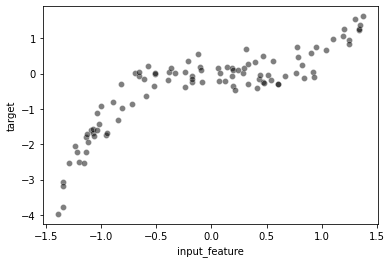

In [6]:
# visualize the data
sns.scatterplot(data=full_data, x="input_feature", y="target",
                    color="black", alpha=0.5);

We will first highlight the limitations of fitting a linear regression model as done in the previous exercise.

In [7]:
# X should be 2D for sklearn: (n_samples, n_features)
data = data.reshape((-1, 1))
data.shape

(100, 1)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [10]:
linear_regression = LinearRegression()
linear_regression.fit(data, target)
target_predicted = linear_regression.predict(data)

In [11]:
mse = mean_squared_error(target, target_predicted)

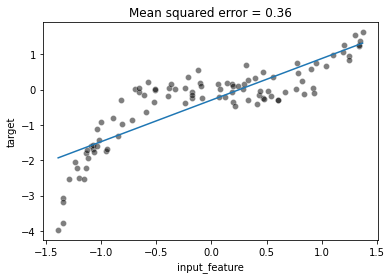

In [12]:
ax = sns.scatterplot(data=full_data, x="input_feature", y="target",
                     color="black", alpha=0.5)
ax.plot(data, target_predicted)
ax.set_title(f"Mean squared error = {mse:.2f}");

Here the coefficient and intercept learnt by `LinearRegression` define the best "straight line" that fits the data. We can inspect the coefficients using the attributes of the learned model as follows:

In [13]:
print(f"weight: {linear_regression.coef_[0]:.2f}, "
      f"intercept: {linear_regression.intercept_:.2f}")

weight: 1.18, intercept: -0.29
